<a href="https://colab.research.google.com/github/hyesunyun/movie-rec-sys/blob/main/movie_rec_sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using NLP to create a movie recommendation system

We will use **content-based filtering** to create a recommendation system.

To do this, we will use NLP techniques to **represent text as vectors and embeddings**.
Then, use **cosine similarity** as a measure to determine the similarity between movies to recommend them to users.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import nltk
import torch
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import DistilBertTokenizer, DistilBertModel

# Import necessary libraries for visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the IMDB 5000 movies dataset
url = "https://raw.githubusercontent.com/fenago/datasets/refs/heads/main/tmdb_5000_movies.csv"
df = pd.read_csv(url)
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [3]:

# some initial preprocessing
df = df[['overview', 'genres', 'original_title', 'keywords']].dropna()
# Fill missing values in 'overview' with an empty string
df['overview'] = df['overview'].fillna('')

# Define a function to extract names from a list of dictionaries
# This function assumes that the input is a string representation of a list of dictionaries
# and extracts the 'name' field from each dictionary
def extract_names_from_dicts(dict_list):
    if isinstance(dict_list, str):
        return dict_list
    if isinstance(dict_list, list):
        return ' '.join([d['name'] for d in dict_list if isinstance(d, dict)])
    return ''

# Convert 'genres' and 'keywords' to string
df['genres'] = df['genres'].apply(lambda x: extract_names_from_dicts(eval(x)))
df['keywords'] = df['keywords'].apply(lambda x: extract_names_from_dicts(eval(x)))

# Combine all text columns into a single column
df['movie_text'] = df['original_title'] + ' ' + df['overview'] + ' ' + df['genres'] + ' ' + df['keywords']

In [4]:
# Ensure all values in 'movie_text' are strings
df['movie_text'] = df['movie_text'].astype(str)
df.head()

,overview,genres,original_title,keywords,movie_text
0,"In the 22nd century, a paraplegic Marine is di...",Action Adventure Fantasy Science Fiction,Avatar,culture clash future space war space colony so...,"Avatar In the 22nd century, a paraplegic Marin..."
1,"Captain Barbossa, long believed to be dead, ha...",Adventure Fantasy Action,Pirates of the Caribbean: At World's End,ocean drug abuse exotic island east india trad...,Pirates of the Caribbean: At World's End Capta...
2,A cryptic message from Bond’s past sends him o...,Action Adventure Crime,Spectre,spy based on novel secret agent sequel mi6 bri...,Spectre A cryptic message from Bond’s past sen...
3,Following the death of District Attorney Harve...,Action Crime Drama Thriller,The Dark Knight Rises,dc comics crime fighter terrorist secret ident...,The Dark Knight Rises Following the death of D...
4,"John Carter is a war-weary, former military ca...",Action Adventure Science Fiction,John Carter,based on novel mars medallion space travel pri...,"John Carter John Carter is a war-weary, former..."


In [5]:
# Define a text preprocessing function
def preprocess_text(text):
    # Convert to string if it's not already
    if not isinstance(text, str):
        text = str(text)

    # 1. Lowercase the text
    text = text.lower()

    # 2. Tokenize the text
    tokens = word_tokenize(text)

    # 3. Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # 4. Lemmatize the tokens
    # Examples: running -> run, better -> good
    # https://en.wikipedia.org/wiki/Lemmatization
    # Note: Lemmatization requires the WordNet corpus
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # return tokens
    return " ".join(tokens)

In [6]:
# Apply the text preprocessing function directly to the 'movie_text' column
df['processed_movie_text'] = df['movie_text'].apply(preprocess_text)

# Display the first 5 rows of the 'movie_text' column after preprocessing
df['processed_movie_text'].head()

,processed_movie_text
0,avatar 22nd century paraplegic marine dispatch...
1,pirate caribbean world end captain barbossa lo...
2,spectre cryptic message bond past sends trail ...
3,dark knight rise following death district atto...
4,john carter john carter former military captai...


## Vectors

- Bag-of-Words (Binary & Frequency)
- TF-IDF

In [7]:
# function for getting recommendations from matrix of vectorized movie texts
# generate movie recommendation function that takes a movie title and returns the top n similar movies with similarity scores
def recommend_movies(matrix, movie_title, top_n=5):
    # Check if the movie title is in the dataset
    if movie_title not in df['original_title'].values:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return []

    # Get the index of the movie
    movie_index = df[df['original_title'] == movie_title].index[0]

    # Calculate cosine similarity
    cosine_similarities = cosine_similarity(matrix[movie_index], matrix).flatten()

    # Get the indices of the top N similar movies
    similar_indices = np.argsort(cosine_similarities)[::-1][1:top_n+1]

    # Get the titles and similarity scores of the top N similar movies
    similar_movies = [(df.iloc[i]['original_title'], cosine_similarities[i]) for i in similar_indices]

    return similar_movies

In [8]:
def print_recommended_movies(recommended_movies):
    # Print the recommended movies in a tabular format
    print(f"{'Title':<50} {'Similarity Score':<15}")
    print("-" * 65)
    for movie in recommended_movies:
        print(f"{movie[0]:<50} {movie[1]:<15.4f}")

In [ ]:
# Binary Bag of Words
vectorizer_binary = CountVectorizer(binary=True)
binary_matrix = vectorizer_binary.fit_transform(df['processed_movie_text'])

binary_matrix.shape

(4800, 21368)

In [ ]:
# Example usage
recommended_movies = recommend_movies(binary_matrix, "Transformers", 10)
print("Recommended movies for 'Transformers':")
print_recommended_movies(recommended_movies)

Recommended movies for 'Transformers':
Title                                              Similarity Score
-----------------------------------------------------------------
Transformers: Revenge of the Fallen                0.3248         
Transformers: Age of Extinction                    0.2726         
Transformers: Dark of the Moon                     0.2610         
I Am Number Four                                   0.2428         
Man of Steel                                       0.2339         
The Darkest Hour                                   0.2215         
X-Men                                              0.2215         
Divergent                                          0.2192         
Race to Witch Mountain                             0.2192         
Zathura: A Space Adventure                         0.2182         


In [11]:
# Bag-of-Words
vectorizer_bow = CountVectorizer()
bow_matrix = vectorizer_bow.fit_transform(df['processed_movie_text'])

bow_matrix.shape

(4800, 21368)

In [12]:
recommended_movies = recommend_movies(bow_matrix, "22 Jump Street", 10)
print("Recommended movies for '22 Jump Street':")
print_recommended_movies(recommended_movies)

Recommended movies for '22 Jump Street':
Title                                              Similarity Score
-----------------------------------------------------------------
21 Jump Street                                     0.4326         
Underclassman                                      0.3489         
College                                            0.3174         
Superbad                                           0.2810         
The Spectacular Now                                0.2584         
The DUFF                                           0.2484         
High School Musical 3: Senior Year                 0.2478         
The Dirties                                        0.2437         
There Goes My Baby                                 0.2437         
Big Mommas: Like Father, Like Son                  0.2422         


In [13]:
# TF-IDF
vectorizer_tfidf = TfidfVectorizer()
tfidf_matrix = vectorizer_tfidf.fit_transform(df['processed_movie_text'])

tfidf_matrix.shape

(4800, 21368)

In [14]:
recommended_movies = recommend_movies(tfidf_matrix, "22 Jump Street", 10)
print("Recommended movies for '22 Jump Street':")
print_recommended_movies(recommended_movies)

Recommended movies for '22 Jump Street':
Title                                              Similarity Score
-----------------------------------------------------------------
21 Jump Street                                     0.3517         
Underclassman                                      0.2118         
College                                            0.2053         
Hoop Dreams                                        0.1567         
Superbad                                           0.1525         
The Spectacular Now                                0.1440         
When the Game Stands Tall                          0.1427         
2 Guns                                             0.1340         
High School Musical 3: Senior Year                 0.1316         
Point Break                                        0.1313         


In [15]:
recommended_movies = recommend_movies(tfidf_matrix, "Avatar", 10)
print("Recommended movies for 'Avatar':")
print_recommended_movies(recommended_movies)

Recommended movies for 'Avatar':
Title                                              Similarity Score
-----------------------------------------------------------------
Aliens                                             0.3323         
Mission to Mars                                    0.2776         
Alien³                                             0.2730         
Alien                                              0.2702         
Moonraker                                          0.2595         
Treasure Planet                                    0.2539         
2001: A Space Odyssey                              0.2498         
Silent Running                                     0.2458         
Lifeforce                                          0.2451         
Meet Dave                                          0.2406         


## Word2Vec

In [16]:
# Word2Vec
sentences = [text.split() for text in df['processed_movie_text']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

In [17]:
# Display the vocabulary size
print(f"Vocabulary size: {len(word2vec_model.wv.index_to_key)}")

# Extract 10 words from the model's vocabulary
words = word2vec_model.wv.index_to_key[:10]

# Create a DataFrame to display words and their embeddings
word_embeddings = [word2vec_model.wv[word] for word in words]
embeddings_df = pd.DataFrame(word_embeddings, index=words)

# Display the DataFrame with 10 words and their corresponding embeddings
print(embeddings_df)

Vocabulary size: 12449
                 0         1         2         3         4         5   \
drama     -2.168958  0.895151  0.500719  0.910999  0.215291 -1.133260   
comedy    -2.191331  0.914221  0.557592  0.878851  0.353100 -1.175704   
thriller  -2.418179  0.905550  0.140128  0.314770  0.350933 -1.030777   
family    -1.866197  0.993698  0.451988  0.607596  0.344921 -1.069494   
life      -0.596495  0.689332  0.458608  0.366113  0.445548 -1.288678   
action    -2.183381  0.828403  0.187934  0.204657  0.324917 -0.871686   
romance   -1.882902  0.889522  0.481026  0.996987  0.221378 -1.293402   
new       -0.191272 -0.244440  0.545984  0.634440  0.029888 -1.348169   
adventure -2.295431  1.045469  0.480408  0.579872  0.443025 -0.940796   
crime     -2.201270  0.715538  0.119089  0.557488  0.270706 -0.987158   

                 6         7         8         9   ...        90        91  \
drama      1.618561  0.839882 -1.508598 -1.172245  ...  1.222542  0.220495   
comedy     1.5633

To gain insight into the word vectors learned by Word2Vec, we'll use PCA to reduce the dimensionality of our word vectors and plot 100 random words.

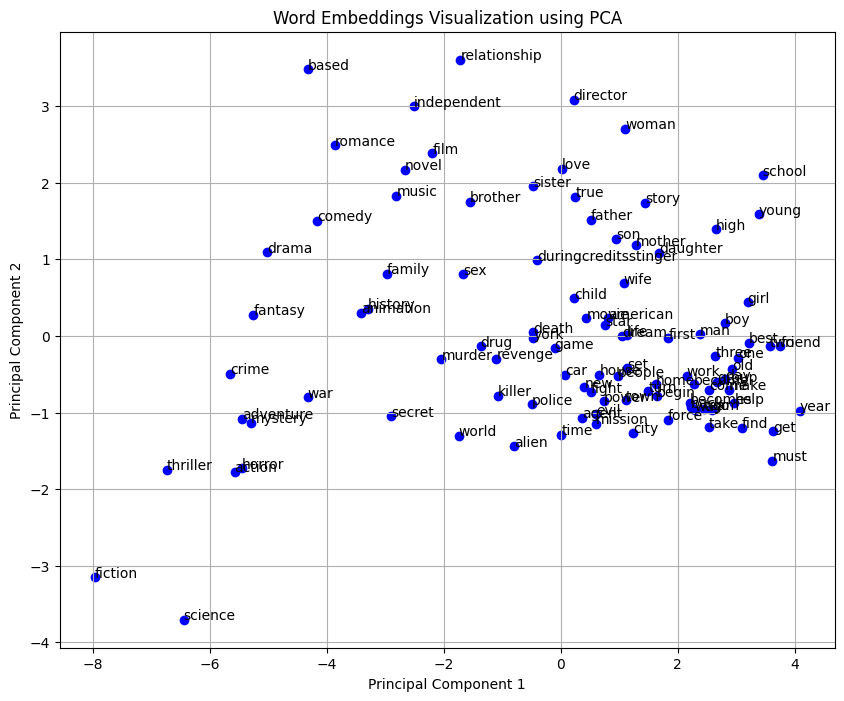

In [18]:
# Select 100 random words from the vocabulary
words = list(word2vec_model.wv.index_to_key)[:100]

# Get the word embeddings for these words
word_vectors = [word2vec_model.wv[word] for word in words]

# Use PCA to reduce the word vectors to 2 dimensions
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], c='blue')

# Annotate each point with the word
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]))

# Display the plot
plt.title("Word Embeddings Visualization using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

Next, we'll create an embedding for each movie by averaging the embeddings of all words in the processed_movie_text.

In [19]:
# function to get the average word2vec vector for a given text
def get_average_word2vec(text):
    words = text.split()
    vector = np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv], axis=0)
    return vector if isinstance(vector, np.ndarray) else np.zeros(100)

# Create a matrix of average word2vec vectors for each movie
# This will create a matrix where each row corresponds to a movie and each column corresponds to a dimension of the word2vec vector
word2vec_matrix = np.array([get_average_word2vec(text) for text in df['processed_movie_text']])

In [20]:
# function to recommend movies using Word2Vec
def recommend_movies_word2vec(movie_title, top_n=5):
    # Check if the movie title is in the dataset
    if movie_title not in df['original_title'].values:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return []

    # Get the index of the movie
    movie_index = df[df['original_title'] == movie_title].index[0]

    # Calculate cosine similarity
    cosine_similarities = cosine_similarity(word2vec_matrix[movie_index].reshape(1, -1), word2vec_matrix).flatten()

    # Get the indices of the top N similar movies
    similar_indices = np.argsort(cosine_similarities)[::-1][1:top_n+1]

    # Get the titles and similarity scores of the top N similar movies
    similar_movies = [(df.iloc[i]['original_title'], cosine_similarities[i]) for i in similar_indices]

    return similar_movies

In [21]:
recommended_movies = recommend_movies_word2vec("Avatar", 20)
print("Recommended movies for 'Avatar':")
print_recommended_movies(recommended_movies)

Recommended movies for 'Avatar':
Title                                              Similarity Score
-----------------------------------------------------------------
Star Wars: Episode I - The Phantom Menace          0.9997         
Transformers: Revenge of the Fallen                0.9996         
Jurassic World                                     0.9993         
The Ice Pirates                                    0.9992         
The League of Extraordinary Gentlemen              0.9990         
Batman                                             0.9989         
The Book of Eli                                    0.9989         
Under the Skin                                     0.9988         
Mars Attacks!                                      0.9988         
Dune                                               0.9988         
Underworld: Evolution                              0.9987         
Gattaca                                            0.9987         
The Darkest Hour             

In [22]:
recommended_movies = recommend_movies_word2vec("Shrek", 10)
print("Recommended movies for 'Shrek':")
print_recommended_movies(recommended_movies)

Recommended movies for 'Shrek':
Title                                              Similarity Score
-----------------------------------------------------------------
Kung Fu Panda 3                                    0.9990         
Hotel Transylvania                                 0.9987         
Hoodwinked Too! Hood VS. Evil                      0.9987         
The Greatest Movie Ever Sold                       0.9986         
Benji                                              0.9986         
The Book of Life                                   0.9985         
Everything You Always Wanted to Know About Sex *But Were Afraid to Ask 0.9985         
Alvin and the Chipmunks                            0.9985         
Practical Magic                                    0.9984         
Aladdin                                            0.9983         


Ways to improve the performance:
- **Increase the vector size**: Using larger vectors (e.g., 200 or 300 dimensions) may capture more information about the words and result in better recommendations. However, this may also increase memory usage and computation time.
- **Tune hyperparameters**: Experiment with different Word2Vec hyperparameters such as window, min_count, and negative to find the best combination for your specific dataset. Additionally, you could try different training algorithms (sg=0 for CBOW, sg=1 for skip-gram) and adjust the learning rate (alpha).
- **Use pre-trained embeddings**: Instead of training your own Word2Vec model, you could use pre-trained word embeddings like GloVe or FastText. These models have been trained on massive text corpora and could provide better representations of words in the movie content.
- **Text preprocessing**: Improve the text preprocessing steps by performing better tokenization, stemming or lemmatization, and filtering out less informative words or phrases. This can help the model better capture the essence of each movie’s content.
- **Combine features**: Instead of using only Word2Vec embeddings, you could also try combining them with other features like TF-IDF, Bag of Words, or
- **Use Doc2Vec**: Instead of averaging Word2Vec embeddings, you could use the Doc2Vec model, which is specifically designed for representing entire documents. Doc2Vec can better capture the semantics of the entire text and might provide better recommendations.

## BERT (DistilBERT)

You will need a GPU to run this part of the code. Make sure your runtime on Google Colab is on GPU.

In [23]:
# BERT Word Embeddings
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased', output_hidden_states=True).to('cuda')

# Function to get BERT embeddings for a given text
def get_bert_embedding(text):
    # Tokenize the input text and prepare it for the BERT model
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length').to('cuda')

    # Disable gradient calculation for inference
    with torch.no_grad():
        # Pass the tokenized input through the BERT model
        outputs = bert_model(**inputs)

        # Extract the last 4 hidden states from the model's output
        hidden_states = outputs.hidden_states[-4:]

        # Sum the last 4 hidden states to create a single embedding
        sum_last_four_layers = torch.sum(torch.stack(hidden_states), dim=0)

    # Return the embedding for the [CLS] token (first token) as a numpy array
    return sum_last_four_layers[:, 0, :].cpu().squeeze().numpy()

bert_matrix = np.array([get_bert_embedding(text) for text in df['processed_movie_text']])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


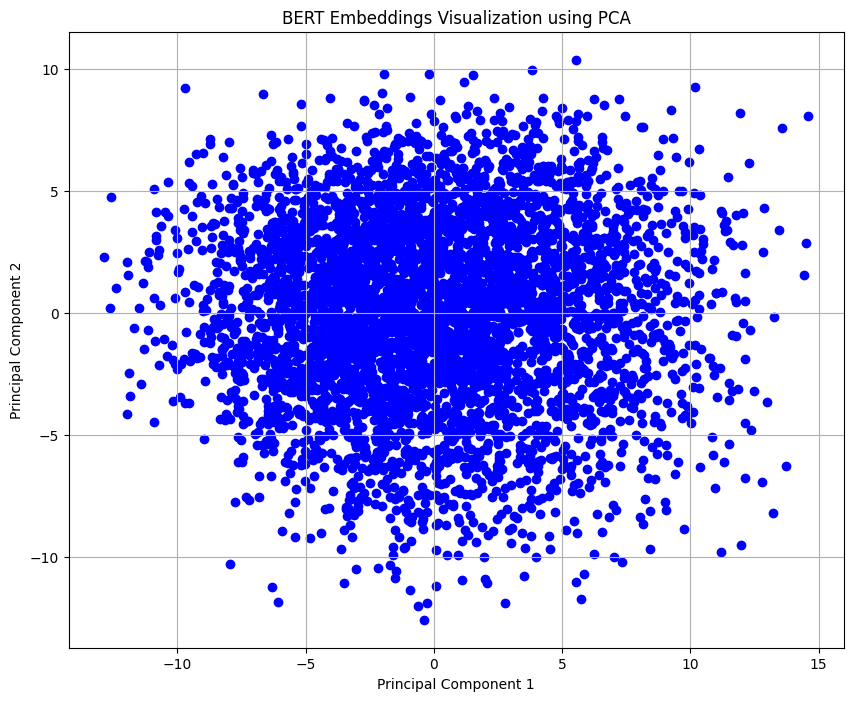

In [24]:
# Use PCA to reduce the word vectors to 2 dimensions
# visualize the BERT embeddings using PCA
pca = PCA(n_components=2)
bert_matrix_pca = pca.fit_transform(bert_matrix)
plt.figure(figsize=(10, 8))
plt.scatter(bert_matrix_pca[:, 0], bert_matrix_pca[:, 1], c='blue')
plt.title("BERT Embeddings Visualization using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

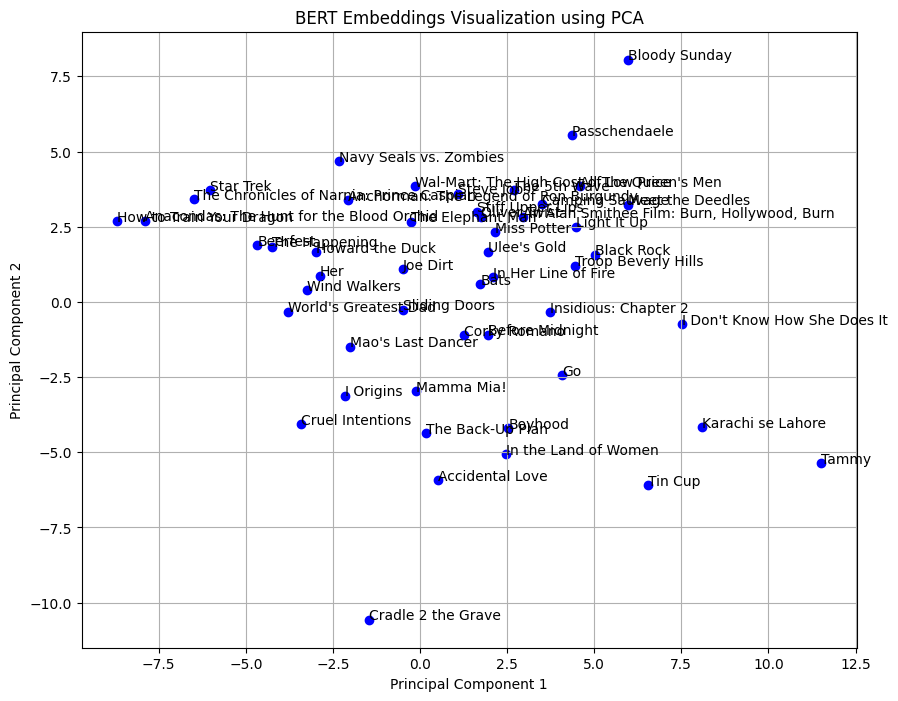

In [25]:
# visualize 50 random embeddings
indices = np.random.choice(bert_matrix_pca.shape[0], 50, replace=False)
plt.figure(figsize=(10, 8))
plt.scatter(bert_matrix_pca[indices, 0], bert_matrix_pca[indices, 1], c='blue')
for i in indices:
    plt.annotate(df['original_title'].iloc[i], xy=(bert_matrix_pca[i, 0], bert_matrix_pca[i, 1]))
plt.title("BERT Embeddings Visualization using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

In [26]:
# function to recommend movies using BERT
def recommend_movies_bert(movie_title, top_n=5):
    # Check if the movie title is in the dataset
    if movie_title not in df['original_title'].values:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return []

    # Get the index of the movie
    movie_index = df[df['original_title'] == movie_title].index[0]

    # Calculate cosine similarity
    cosine_similarities = cosine_similarity(bert_matrix[movie_index].reshape(1, -1), bert_matrix).flatten()

    # Get the indices of the top N similar movies
    similar_indices = np.argsort(cosine_similarities)[::-1][1:top_n+1]

    # Get the titles and similarity scores of the top N similar movies
    similar_movies = [(df.iloc[i]['original_title'], cosine_similarities[i]) for i in similar_indices]

    return similar_movies

In [27]:
recommended_movies = recommend_movies_bert("Avatar", 10)
print("Recommended movies for 'Avatar':")
print_recommended_movies(recommended_movies)

Recommended movies for 'Avatar':
Title                                              Similarity Score
-----------------------------------------------------------------
Beastmaster 2: Through the Portal of Time          0.9895         
Terminator Genisys                                 0.9886         
Titan A.E.                                         0.9885         
Star Trek Into Darkness                            0.9883         
The Matrix                                         0.9882         
Dawn of the Planet of the Apes                     0.9879         
Final Fantasy: The Spirits Within                  0.9877         
TRON: Legacy                                       0.9871         
The Matrix Revolutions                             0.9869         
Resident Evil: Apocalypse                          0.9868         


In [28]:
recommended_movies = recommend_movies_word2vec("Shrek", 10)
print("Recommended movies for 'Shrek':")
print_recommended_movies(recommended_movies)

Recommended movies for 'Shrek':
Title                                              Similarity Score
-----------------------------------------------------------------
Kung Fu Panda 3                                    0.9990         
Hotel Transylvania                                 0.9987         
Hoodwinked Too! Hood VS. Evil                      0.9987         
The Greatest Movie Ever Sold                       0.9986         
Benji                                              0.9986         
The Book of Life                                   0.9985         
Everything You Always Wanted to Know About Sex *But Were Afraid to Ask 0.9985         
Alvin and the Chipmunks                            0.9985         
Practical Magic                                    0.9984         
Aladdin                                            0.9983         


In [29]:
recommended_movies = recommend_movies_word2vec("The Empire Strikes Back", 10)
print("Recommended movies for 'The Empire Strikes Back':")
print_recommended_movies(recommended_movies)

Recommended movies for 'The Empire Strikes Back':
Title                                              Similarity Score
-----------------------------------------------------------------
U.F.O.                                             0.9998         
Pitch Black                                        0.9998         
Universal Soldier: The Return                      0.9997         
All Superheroes Must Die                           0.9997         
The Last Days on Mars                              0.9997         
Timeline                                           0.9997         
Queen Crab                                         0.9996         
Terminator 3: Rise of the Machines                 0.9996         
Predator                                           0.9996         
The Invasion                                       0.9996         


You can also use [Sentence Transformers](https://sbert.net/) instead of BERT or distilBERT